***(i) Import the function from the module "mzprojection"***

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mzprojection import mzprojection_multivariate, split_long_time_series, calc_correlation

help(mzprojection_multivariate)

Help on function mzprojection_multivariate in module mzprojection.mzprojection:

mzprojection_multivariate(delta_t, u, dudt0, f, flag_terms=False, flag_debug=False)
    Evaluate projection of f(t) on u(t),
      f_i(t) = Omega_ij*u_j(t) - int_0^t Gamma_ij(s)*u_j(t-s) ds + r_i(t)
    taking summation over the repeated index j.
    
    Parameters
    ----------
    delta_t : float
        Time step size
    u[nsample,nperiod,nu] : Numpy array (float64 or complex128)
        Explanatory variable u_j(t).
        nsample is the number of samples.
        nperiod is the number of time steps of a short-time data.
        nu is the number of independent explanatory variable (j=0,1,...,nu-1).
    dudt0[nsample,nu] : Numpy array (float64 or complex128)
        = du/dt(t=0)
    f[nsample,nperiod,nf] : Numpy array (float64 or complex128)
        Response variable f_i(t).
        nf is the number of independent response variables (i=0,1,...,nf-1).
        If 2D array f[nsample,nperiod] is passed, 

***(ii) Prepare ensemble of time series data***  
Here, we split a long time-series data of statistically steady state into a number of samples of short-time data.

t_raw[:].shape= (20000,)
u_raw[:,nu].shape= (20000, 18)
f_raw[:,nf].shape= (20000, 18) # nu/=nf is available.


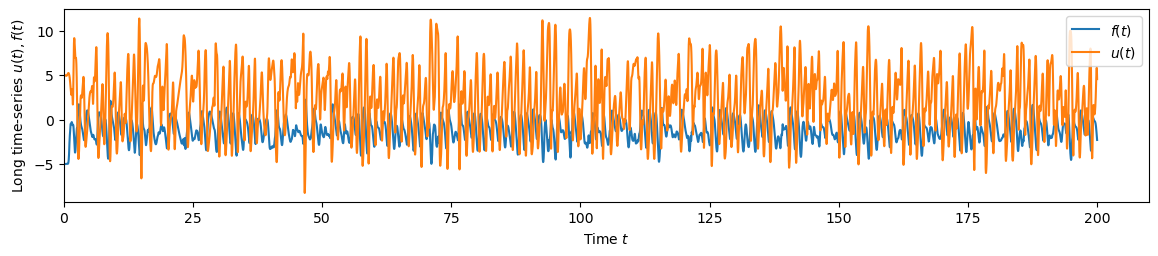

In [2]:
#= Read sample data =
ds = xr.open_dataset('../sample_data/sample_multivariate_L96xy.nc')
t_raw    = np.array(ds.t)      # Time t
u_raw    = np.array(ds.u).T    # Variable of interest u(t)
dudt_raw = np.array(ds.dudt).T # = du/dt
f_raw    = np.array(ds.f).T    # Analyzed data f(t)
print("t_raw[:].shape=",t_raw.shape)
print("u_raw[:,nu].shape=",u_raw.shape)
print("f_raw[:,nf].shape=",f_raw.shape,"# nu/=nf is available.")

fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Long time-series $u(t), f(t)$")
ax.plot(t_raw,f_raw[:,0],label="$f(t)$")
ax.plot(t_raw,u_raw[:,0],label="$u(t)$")
ax.set_xlim(0,None)
plt.legend()
plt.show()

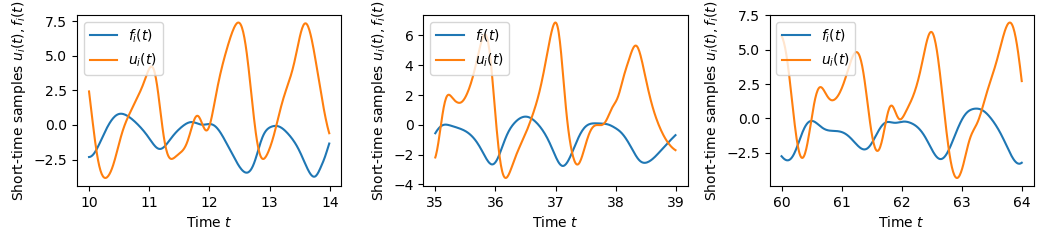

In [3]:
#= Split a long time series data into samples of short-time data =
ista    = 1000                # Start time step number for sampling   
nperiod = 400                 # Time step length of a short-time sample                 
nshift  = 10                  # Length of time shift while sampling
t   =split_long_time_series(t_raw,ista=ista,nperiod=nperiod,nshift=nshift)
u   =split_long_time_series(u_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt=split_long_time_series(dudt_raw,ista=ista,nperiod=nperiod,nshift=nshift)
f   =split_long_time_series(f_raw,ista=ista,nperiod=nperiod,nshift=nshift)
dudt0 = dudt[:,0] # dudt0[nsample], dudt[nsample,nperiod] 

fig = plt.figure(figsize=(14,2.5))
samples = [0,250,500]
for i in range(len(samples)):
    ax = fig.add_subplot(int("14{:}".format(i+1)))
    isample = samples[i]
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel(r"Short-time samples $u_i(t), f_i(t)$")
    ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t)$")
    ax.plot(t[isample,:],u[isample,:,0],label=r"$u_i(t)$")
    ax.legend()
fig.tight_layout()
plt.show()

***(iii) Apply the Moti-Zwanzig projection operator method***  
The projection of $\boldsymbol{f}(t)$ on $\boldsymbol{u}(t)$ is calculated as,  
    $\boldsymbol{f}(t)=\Omega \cdot \boldsymbol{u}(t)+\boldsymbol{s}(t)+\boldsymbol{r}(t)$,  
    $\boldsymbol{s}(t)=-\int_0^t \Gamma(t) \cdot \boldsymbol{u}(t-v)dv$.  
The Markov coefficient $\Omega$, the memory function $\Gamma(t)$ and the uncorrelated term $\boldsymbol{r}(t)$ are obtained as outputs.  
(Some correlations, e.g., $\langle \boldsymbol{r}(t) \boldsymbol{u} \rangle$ are also obtained to check the result.)

In [4]:
delta_t = t_raw[1] - t_raw[0] # Time step size
omega, memoryf, s, r = mzprojection_multivariate(delta_t, u, dudt0, f, flag_terms=True, flag_debug=True)
t_cor = delta_t * np.arange(memoryf.shape[0])

nsample= 1861 , nperiod= 400 , nu= 18 , nf= 18
# Elapsed time to prepare correlations [sec]: 0.5280687808990479
      uu0_inv[nu,nu].shape= (18, 18) float64
ududt[nperiod,nu,nu].shape= (400, 18, 18) float64
    G[nperiod,nu,nu].shape= (400, 18, 18) float64
      wG0_inv[nu,nu].shape= (18, 18) float64
# Elapsed time to calc. omega & memoryf [sec]: 0.6765918731689453
          omega[nf,nu].shape= (18, 18) float64
memoryf[nperiod,nf,nu].shape= (400, 18, 18) float64
# Elapsed time to calc. residual r [sec]: 3.480346441268921
s[nsample,nperiod,nf].shape= (1861, 400, 18) float64
r[nsample,nperiod,nf].shape= (1861, 400, 18) float64


***(iv-a) Check results: plot $\Omega$ and $\Gamma(t)$***  

Markov coefficient matrix Omega =  -0.23643966439861006


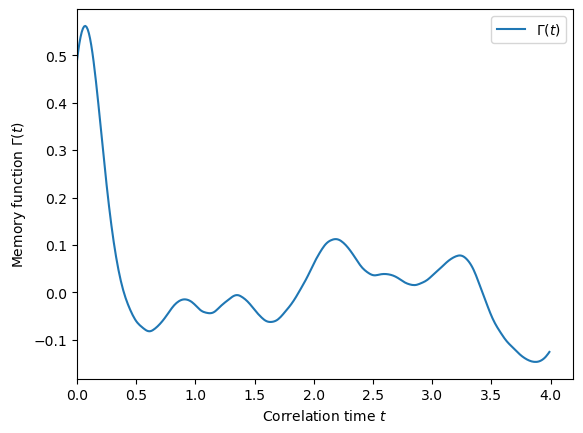

In [5]:
print("Markov coefficient matrix Omega = ", omega[0,0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time $t$")
ax.set_ylabel("Memory function $\Gamma(t)$")
ax.plot(t_cor,memoryf[:,0,0],label="$\Gamma(t)$")
ax.set_xlim(0,None)
plt.legend()
plt.show()

***(iv-b) Check results: plot time evolution of $\boldsymbol{f}(t)=\Omega \cdot \boldsymbol{u}(t)+\boldsymbol{s}(t)+\boldsymbol{r}(t)$***  

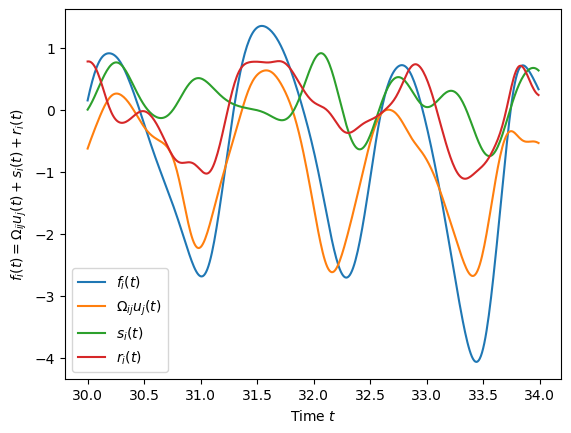

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"$f_i(t)=\Omega_{ij}u_j(t)+s_i(t)+r_i(t)$")
isample=200
ax.plot(t[isample,:],f[isample,:,0],label=r"$f_i(t)$")
ax.plot(t[isample,:],np.dot(u[isample,:,:],omega.T)[:,0],label=r"$\Omega_{ij}u_j(t)$")
ax.plot(t[isample,:],s[isample,:,0],label=r"$s_i(t)$")
ax.plot(t[isample,:],r[isample,:,0],label=r"$r_i(t)$")
plt.legend()
plt.show()

***(iv-c) Check results: Extended generalized fluctuation-dissipation theorem $\Gamma(t) = \langle \boldsymbol{r}(t) d\boldsymbol{u}/dt \rangle \cdot \langle \boldsymbol{u} \boldsymbol{u} \rangle^{-1}$***  

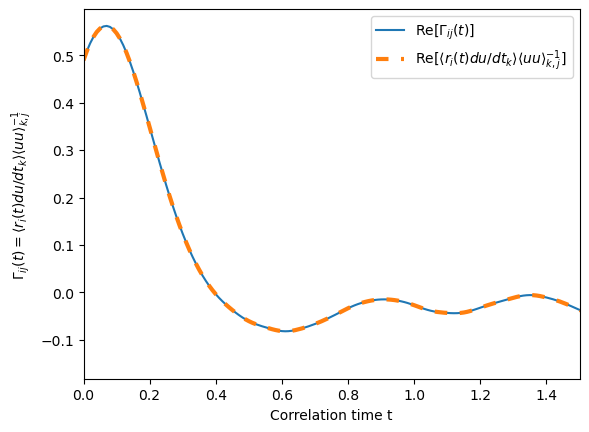

In [7]:
u0 = u[:,0]
f0 = f[:,0]
r0 = r[:,0]
uu = calc_correlation(u,u0)
fu = calc_correlation(f,u0)
rdudt = calc_correlation(r,dudt0)
ru = calc_correlation(r,u0)
uu0_inv = np.linalg.inv(uu[0,:,:])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time t")
ax.set_ylabel(r"$\Gamma_{ij}(t) = \langle r_i(t) du/dt_k \rangle \langle u u \rangle^{-1}_{k,j}$")
ax.plot(t_cor,memoryf[:,0,0],label="Re[$\Gamma_{ij}(t)$]")
ax.plot(t_cor,np.dot(rdudt,uu0_inv)[:,0,0],"--",label=r"Re[$\langle r_i(t) du/dt_k \rangle \langle u u \rangle^{-1}_{k,j}$]",dashes=[3,3],linewidth=3)
ax.set_xlim(0,1.5)
plt.legend()
plt.show()

***(iv-d) Check results: $\langle \boldsymbol{r}(t) \boldsymbol{u} \rangle = 0$***  
Namely, the uncorrelated term $\boldsymbol{r}(t)$ indeed extracts the part of $\boldsymbol{f}(t)$ uncorrelated with $\boldsymbol{u}$. It is checked by $\langle \boldsymbol{r}(t) \boldsymbol{u} \rangle \ll \langle \boldsymbol{f}(t) \boldsymbol{u} \rangle$.

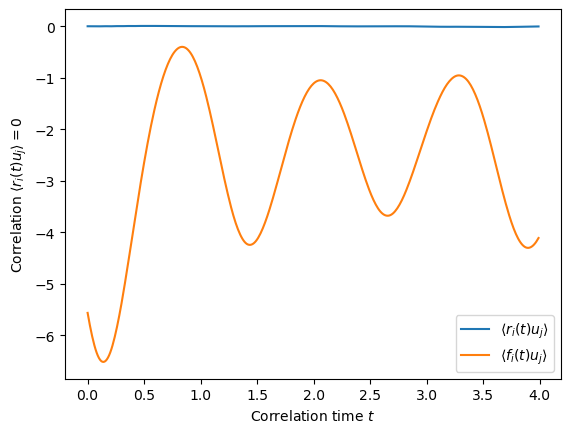

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Correlation time $t$")
ax.set_ylabel(r"Correlation $\langle r_i(t) u_j \rangle = 0$")
ax.plot(t_cor,ru[:,0,0],label=r"$\langle r_i(t) u_j \rangle$")
ax.plot(t_cor,fu[:,0,0],label=r"$\langle f_i(t) u_j \rangle$")
plt.legend()
plt.show()